## Description:
######Model type = LSTM
######Hidden layers = 32*2
######train seq_len = 200
######model id = lstm32-200


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import io

In [3]:
#mount google drive on colab for saving pytorch model variables
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Data Loading

In [4]:
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
test_data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_valid.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
with io.open(data_path, 'r', encoding = 'utf8') as f:
    text = f.read()
with io.open(test_data_path, 'r', encoding = 'utf8') as f:
    test_text = f.read()

chars = set(text)
tchars = set(test_text)
char2int = {c:i for i,c in enumerate(chars)}
int2char = dict(enumerate(chars))
nptext = np.array([char2int[ch] for ch in text])
npttext = np.array([char2int[ch] for ch in test_text])

N = nptext.shape[0]
tN = npttext.shape[0]
Nc = len(chars)
tNc = len(tchars)
for ele in tchars:
    assert(ele in chars)
print("all elememts in test data is in train data")
print("total train data length = {}, there are {} kinds of character".format(N, Nc))
print("total test data length = {}, there are {} kinds of character".format(tN, tNc))

all elememts in test data is in train data
total train data length = 4351312, there are 67 kinds of character
total test data length = 222025, there are 62 kinds of character


Hyper Params


In [0]:
#data
seq_len = 200
batch_size = 12
#model:
hidden_size = 32
n_layers = 2
#traininng:
n_epoch = 30
lr = 1e-4
dropout = 0.2
print_every = 1  #generate text per 2 epoch
plot_every = 100 #calc accuracy/loss per 100 batch
#model/record saving/loading:
LOAD = False
data_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/data/shakespeare_train.txt"
model_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/model/"
rec_path = "/content/gdrive/My Drive/Colab Notebooks/DL19_HW3/rec/"
model_id = "lstm32-200" #save as 
load_model_name = None
rec_name = "rec-"+ model_id + ".pkl"
load_rec_name = "rec-"+ model_id + ".pkl"

Preprocessing Data

In [6]:
from typing import List, Union #python 3.8 requried
num = Union[int, float]
def chunks(arr, chunk_len):
    for i in range(0, len(arr) - chunk_len, chunk_len):
        yield arr[i:i + chunk_len]

def s2tensor(s: str, device: str) -> torch.LongTensor:
    return torch.Tensor([char2int[s[i]] if s[i] in char2int else 0 for i in range(len(s))]).long().to(device)

def tensor2s(t: torch.Tensor) -> str:
    val = t.cpu().detach().numpy()
    ret = "" 
    return ret.join([int2char[val[i]] for i in range(len(val))])

#preprocessing train data:
seqs = list(chunks(nptext, seq_len + 1))
batches = list(chunks(seqs, batch_size))
train_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in batches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(train_data), train_data[0].shape)

#preprocessing test data:
tseqs = list(chunks(npttext, seq_len + 1))
tbatches = list(chunks(tseqs, batch_size))
test_data = [torch.LongTensor(batch).transpose_(0, 1) for batch in tbatches] #.transpose_(0, 1) => not batch first
#shape = (#batch, seqlen+1atch, batch_size)
print(len(test_data), test_data[0].shape)
#rint(tensor2s(test_data[0].transpose_(0, 1)[0]))

1803 torch.Size([201, 12])
91 torch.Size([201, 12])


Model

In [0]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type="rnn", n_layers=2, drop_out=0.2):
        super(CharRNN, self).__init__()
        self.cell_type = cell_type.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden) #print(output.shape)
        output = self.decoder(output) #print(output.shape)
        return output, hidden
    def forwardc(self, input, hidden, device='cpu'): #for characters : torch([long]) to distribution
        input = input.view(1, 1).to(device) #batch = 1, len = 1 #need to be added:to(device)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded, hidden)
        output = self.decoder(output)
        output = output.view(self.input_size)
        #print(output)
        return output, hidden

    def init_hidden(self, batch_size=batch_size, device='cpu'):
        if self.cell_type == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device))

Generate Prediction with temparature


In [0]:
def generate(model, device='cpu', seed='Juliet', predict_len=150, tau=0.8): 
    seed_tensor = s2tensor(seed, device) #shape = torch.Size([seqlen])
    #generate hidden 
    h = model.init_hidden(batch_size=1, device=device)
    for x in seed_tensor:
        _, h = model.forwardc(x, h, device)
    #generate seq
    inc = seed_tensor[-1]
    ret = seed
    for i in range(predict_len):
        out, h =  model.forwardc(inc, h, device)
        if tau >= 0.2 :
            tau_distribution = out.detach().data.view(-1).div(tau).exp()
            predi = torch.multinomial(tau_distribution, 1)[0]
        else : #prevent overflow
            _, predi = torch.max(out.detach().data, 0)
        ret += int2char[predi.item()]
        inc = torch.LongTensor([predi])
    return ret

In [0]:
def calc_accuracy(model, data, n_batch=10, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    l = np.random.randint(0, len(data)-n_batch)
    r = l+n_batch
    correct_predictions = 0.0
    total = 0.0
    for batch_tensor in data[l:r]:
        hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
        input_variable = Variable(batch_tensor[:-1]).to(device)
        target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
        # prediction and calculate loss
        output, _ = model(input_variable, hidden)
        output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
        _, predicted = torch.max(output.data, 1)
        #print(tensor2s(predicted))
        total += predicted.size(0)
        correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

In [0]:
def random_train_seq(model, data, n_seq=1, device='cpu'):
    #eval accuracy for model on data with n_batch random batches, rach batch itself is continueous
    ridx = np.random.randint(0, len(data))
    batch_tensor = data[ridx]
    l = np.random.randint(0, batch_tensor.size(1)-n_seq)
    r = l+n_seq
    correct_predictions = 0.0
    total = 0.0
    hidden = model.init_hidden(batch_size=batch_tensor.size(1), device=device)
    input_variable = Variable(batch_tensor[:-1][l:r]).to(device)
    target_variable = Variable(batch_tensor[1:][l:r]).to(device)
    output, _ = model(input_variable, hidden)
    output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
    _, predicted = torch.max(output.data, 1)
    #print(batch_tensor.size())
    print(tensor2s(batch_tensor.transpose_(0,1)[0]))
    print(tensor2s(predicted))
    total += predicted.size(0)
    correct_predictions += (predicted.long() == target_variable.long()).sum()
    return (correct_predictions/total).item()

Test Functionality

In [11]:
def test_model(cell_type="rnn", device='cpu'):
    print("testing {} model".format(cell_type))
    model = CharRNN(Nc, hidden_size, Nc, cell_type=cell_type, n_layers=2)
    model.to(device)
    print("test forward")
    tout, thidden = model(train_data[0].to(device), model.init_hidden(batch_size, device))
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test forwardc")
    tout, thidden = model.forwardc(torch.LongTensor([45]).to(device), model.init_hidden(1, device), device)
    if cell_type=="rnn":
        print(tout.shape, thidden.shape)
    else:
        print(tout.shape, thidden[0].shape, thidden[1].shape)
    print("test cal_accuracy")
    print(calc_accuracy(model, test_data, n_batch=10, device=device))
    print("test random train seq")
    random_train_seq(model, test_data, n_seq=1, device=device)
    print("test generate with forwardc")
    print(generate(model, device, tau=0.1), '\n')
test_model("rnn", "cpu")
test_model("lstm", "cpu")

testing rnn model
test forward
torch.Size([201, 12, 67]) torch.Size([2, 12, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1, 32])
test cal_accuracy
0.010708332993090153
test random train seq
ead with more ill news, for it is full.

BASTARD:
But if you be afeard to hear the worst,
Then let the worst unheard fall on your bead.

KING JOHN:
Bear with me cousin, for I was amazed
Under the tide:
a&Cd3llCCC]C
test generate with forwardc
Julietd!jPGUGSqOXaG!]aH]]aG!!jjbdOjPG!]j'aG!!UjjaGk]b]]qe]qq]]q]aH]q]]q]]q]aHGS
G!jY,G!UjjCaG!3UjYCa]& ]qq]qq]qq]qqq]q]]qOUjY,GS ]& ]qq]q]]q]]]qqk]b]]q]]q]] 

testing lstm model
test forward
torch.Size([201, 12, 67]) torch.Size([2, 12, 32]) torch.Size([2, 12, 32])
test forwardc
torch.Size([67]) torch.Size([2, 1, 32]) torch.Size([2, 1, 32])
test cal_accuracy
0.02720833383500576
test random train seq
ert, father, on my knee
I give heaven thanks I was not like to thee!

KING JOHN:
Why, what a madcap hath heaven lent us here!

QUEEN ELINOR:
He hath a trick of

Train

Build new model

In [12]:
if not LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    record = {
        'loss' : [],
        'trainAC' : [],
        'testAC' : []
    }
    print("new model and record initted")

new model and record initted


Load saved model

In [0]:
if LOAD:
    model = CharRNN(Nc, hidden_size, Nc, cell_type="lstm", n_layers=2)
    model.load_state_dict(torch.load(model_path+load_model_name)['model'])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer.load_state_dict(torch.load(model_path+load_model_name)['optimizer'])
    print('Model parameters loaded from disk.')
    import pickle
    with open(rec_path+load_rec_name, "rb") as fo: 
        record = pickle.load(fo)
    print('Records loaded from disk.')

Use GPU if available

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("model device : ", device)

model device :  cuda:0


In [0]:
import tqdm #set position and leave for colab
import time

def train():
    if not LOAD: 
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    hidden = model.init_hidden(batch_size, device)
    model.train()
    try:
        #epoch_progress = tqdm.tqdm(range(1, n_epoch + 1),position=0, leave=True)
        best_ep_loss = float('inf')
        for epoch in range(1, n_epoch + 1):
            np.random.shuffle(train_data)
            batches_progress = tqdm.tqdm(train_data, position=0, leave=True)
            ep_loss = 0.0
            ep_train_ac = 0.0
            ep_test_ac = 0.0
            cnt = 0.0
            for batch, batch_tensor in enumerate(batches_progress):
                model.train()
                # reset gradients
                model.zero_grad()
                # data
                input_variable = Variable(batch_tensor[:-1]).to(device)
                target_variable = Variable(batch_tensor[1:].contiguous().view(-1)).to(device) #print(target_variable.shape) #(batch_size*seq_len)
                # prediction
                output, _ = model(input_variable, hidden)
                output = output.view(-1,Nc) #(batch_size*seq_len, Nc)
                #loss and backward
                loss = loss_function(output, target_variable)
                loss.backward()
                optimizer.step()
                #record
                if batch%plot_every == 0:
                    _, predicted = torch.max(output.data, 1)
                    total = predicted.size(0)
                    correct_predictions = (predicted.long() == target_variable.long()).sum()
                    train_ac = (correct_predictions*1.0/total).item()
                    test_ac = calc_accuracy(model, test_data, n_batch=1, device=device)
                    loss = loss.item()
                    record['loss'].append(loss), record['trainAC'].append(train_ac), record['testAC'].append(test_ac)
                    ep_loss += loss
                    ep_train_ac += train_ac
                    ep_test_ac += test_ac
                    cnt += 1.0
                    batches_progress.set_postfix(loss='{:.03f}'.format(loss), train_ac='{:.03f}'.format(train_ac), test_ac='{:.03f}'.format(test_ac))

            #epoch_progress.set_postfix(loss='{:.03f}'.format(ep_loss))
            model.eval()
            ep_loss /= cnt
            ep_train_ac /= cnt
            ep_test_ac /= cnt
            best_ep_loss = min(best_ep_loss, loss)
            #generate some ep string
            #time.sleep(0.01)
            tqdm.tqdm.write("\nAt {} epoche, loss = {:.03f}, train ac = {:.03f}, test ac = {:.03f}".format(epoch, ep_loss, ep_train_ac, ep_test_ac))
            seed = 'Juliet'
            tqdm.tqdm.write("RNN write with seed {}".format(seed))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write(generate(model, device, seed, 150))
            tqdm.tqdm.write("\n##############################\n")
            tqdm.tqdm.write("\nrandom test data and prediction:\n")
            random_train_seq(model, test_data, n_seq=1, device=device)
            tqdm.tqdm.write("\n##############################\n")
            
            #save best model in ep as checkpoint
            if loss == best_ep_loss:
                checkpoint_path = os.path.join(model_path, model_id+'checkpoint_ep_'+str(epoch))+ str('{:.03f}'.format(loss)) + '.cp'
                torch.save({
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }, checkpoint_path)

    except KeyboardInterrupt:
        pass

    #save
    model.eval()
    final_path = os.path.join(model_path, model_id+'final_checkpoint_')+ str('{:.03f}'.format(loss)) + '.cp' 
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }, final_path)
    import pickle
    with open(rec_path+rec_name, "wb") as fo: #wb
        pickle.dump(record,fo)
        print('Tranning records saved to disk.')

In [26]:
train()

  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.832, test_ac=0.225, train_ac=0.235]


At 1 epoche, loss = 3.049, train ac = 0.180, test ac = 0.184
RNN write with seed Juliet

##############################

Julieteneeh't in boos at uoe, iun
:d yihe sunt yht hase r te tohey,e yrooo dols leer tooeh af:s tTram soue ss yr woos hyeR
NdDn rhiooe oohg Eaunivlu naam ta

##############################


random test data and prediction:

of our wrath
And sullen presage of your own decay.
An honourable conduct let him have:
Pembroke, look to 't. Farewell, Chatillon.

QUEEN ELINOR:
What now, my son! have I not ever said
How that ambitiou
a eoa

eeooo

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.596, test_ac=0.281, train_ac=0.277]


At 2 epoche, loss = 2.747, train ac = 0.249, test ac = 0.242
RNN write with seed Juliet

##############################

Juliet. Gphll doon tlhss saf:
wolf wann siung.
Big rI, I ret ted eodd  eame.



THNH::
Iot as as nrti naow, nhoel soauve yonns aiter as wign io sy tan hhe i

##############################


random test data and prediction:

 myself,
and by my friends, I am abused: so that,
conclusions to be as kisses, if your four negatives
make your two affirmatives why then, the worse for
my friends and the better for my foes.

DUKE ORS
e   ee nono 

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.440, test_ac=0.295, train_ac=0.321]


At 3 epoche, loss = 2.553, train ac = 0.284, test ac = 0.291
RNN write with seed Juliet

##############################

Julietads shiy beak thol,
Thorly theal hod ovoge mes ceue le man shon ot the hele sy, ir fett

LChive wremd tare, wanr old as tee mal nhet it wend otam pult

##############################


random test data and prediction:

ers; being as like
As rain to water, or devil to his dam.
My boy a bastard! By my soul, I think
His father never was so true begot:
It cannot be, an if thou wert his mother.

QUEEN ELINOR:
There's a go
eaan ennnen 

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.419, test_ac=0.326, train_ac=0.314]


At 4 epoche, loss = 2.439, train ac = 0.313, test ac = 0.291
RNN write with seed Juliet

##############################

Julietle Acvint mole flees telin so nous,

On thed
Thoad on cacpente the mhe the aol the thon she lige shean die ith shushey lot pato sor, id he mithen pand

##############################


random test data and prediction:

VOLIO:
Fool, I'll requite it in the highest degree: I
prithee, be gone.

Clown:

SEBASTIAN:
This is the air; that is the glorious sun;
This pearl she gave me, I do feel't and see't;
And though 'tis won
nnnenetnet e

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.358, test_ac=0.336, train_ac=0.334]


At 5 epoche, loss = 2.375, train ac = 0.328, test ac = 0.317
RNN write with seed Juliet

##############################

Julieted she thit wame ade roth the, Tos;
Theid the sorter pontere ttod the ontt ha the hor he sore fon re, ojle ild hereres fereus hy boind,
Thes yre lend,

##############################


random test data and prediction:

not, an it would please
you to take leave of her, she is very willing to bid
you farewell.

SIR TOBY BELCH:
'Farewell, dear heart, since I must needs be gone.'

MARIA:
Nay, good Sir Toby.

Clown:
'His 
entA netee  

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.286, test_ac=0.348, train_ac=0.353]


At 6 epoche, loss = 2.336, train ac = 0.343, test ac = 0.315
RNN write with seed Juliet

##############################

Juliet rabt yom ere in dint and thit: yir ard thoe hunh! blend to the cintsat
in moult ot the har holis yoe thour!.
Soid shule ther clave'd ale ta in thos h

##############################


random test data and prediction:

e:
Antonio never yet was thief or pirate,
Though I confess, on base and ground enough,
Orsino's enemy. A witchcraft drew me hither:
That most ingrateful boy there by your side,
From the rude sea's enra
neeehtteelee

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.360, test_ac=0.361, train_ac=0.328]


At 7 epoche, loss = 2.301, train ac = 0.343, test ac = 0.355
RNN write with seed Juliet

##############################

Julietare peest
And mothit the -ute bimele that woto so to fers to oll yare oud darts?

LEFIUNE:

A dizR
IOFIDANINE:
So the fos the coand nove.
Sened Ball
T

##############################


random test data and prediction:

a good voyage of nothing. Farewell.

DUKE ORSINO:
Let all the rest give place.
Once more, Cesario,
Get thee to yond same sovereign cruelty:
Tell her, my love, more noble than the world,
Prizes not quan
nenlneeA I e

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.223, test_ac=0.360, train_ac=0.369]


At 8 epoche, loss = 2.257, train ac = 0.355, test ac = 0.328
RNN write with seed Juliet

##############################

Juliet now kour he arliw a hate nrate migh har I'd we bode;
sale bow?
Oe Sollergle to to wich wat resseed.

OLITE:
Dinld I mithel weat on bous, nor than swo

##############################


random test data and prediction:

 you: let's have a song.

SIR ANDREW:
There's a testril of me too: if one knight give a--

Clown:
Would you have a love-song, or a song of good life?

SIR TOBY BELCH:
A love-song, a love-song.

SIR AND
e nee   oee 

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.244, test_ac=0.369, train_ac=0.367]


At 9 epoche, loss = 2.226, train ac = 0.362, test ac = 0.295
RNN write with seed Juliet

##############################

Juliet moke; baes with the wure, lell wiw bimunk'
I welcet do wound teaf coude no arder!

HAUENY:
A anger me the rane priko, you senderfow, for hous shaltam

##############################


random test data and prediction:

 is his prisoner?

LEWIS:
As heartily as he is glad he hath him.

CARDINAL PANDULPH:
Your mind is all as youthful as your blood.
Now hear me speak with a prophetic spirit;
For even the breath of what I
tn ntT
nenhe

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.170, test_ac=0.365, train_ac=0.389]


At 10 epoche, loss = 2.211, train ac = 0.370, test ac = 0.308
RNN write with seed Juliet

##############################

Julietrond merege the at brefut endy all ttem, lirn,
Whaw wowt arcore
Ad, yep she in if and Pithen, I drage on ao's mith, all they blin wher gorshust in hen

##############################


random test data and prediction:

tary.

BASTARD:
All Kent hath yielded; nothing there holds out
But Dover castle: London hath received,
Like a kind host, the Dauphin and his powers:
Your nobles will not hear you, but are gone
To offer
Tn  tet e  t

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.261, test_ac=0.380, train_ac=0.360]


At 11 epoche, loss = 2.197, train ac = 0.368, test ac = 0.342
RNN write with seed Juliet

##############################

Juliet:
As ary coel to the thal bing't houce arlauth, ende hath in saw sheot with laes
So thoustiss
Be, Yous yet lath his me to for beasen
Is a cullen at wo

##############################


random test data and prediction:

er you think, good words, I think, were best.

SALISBURY:
Our griefs, and not our manners, reason now.

BASTARD:
But there is little reason in your grief;
Therefore 'twere reason you had manners now.


 ee t ennhnl

##############################



  0%|          | 0/1803 [00:00<?, ?it/s, loss=2.144, test_ac=0.375, train_ac=0.379]


At 12 epoche, loss = 2.170, train ac = 0.378, test ac = 0.314
RNN write with seed Juliet

##############################

Juliet a that thebes erendor! thou in of of the bighel I cat thit and purtlisr-Sordle; be cowl of the as thaln this than I do Kortyed darike shind tham his 

##############################


random test data and prediction:

utiful
In the contempt and anger of his lip!
A murderous guilt shows not itself more soon
Than love that would seem hid: love's night is noon.
Cesario, by the roses of the spring,
By maidhood, honour, 
le enh tt  n

##############################



 67%|██████▋   | 1199/1803 [07:59<00:08, 67.14it/s, loss=3.245, test_ac=0.153, train_ac=0.149]


At 13 epoche, loss = 2.145, train ac = 0.382, test ac = 0.345
RNN write with seed Juliet

##############################

Julieter hear.

BLLAIP:
Theight.

IREANWENRUR:
For indany low stemt mars not yis where wernririte, and hate lire, this miy, the urikinn thas and fnate my ch

##############################


random test data and prediction:



RuntimeError: ignored

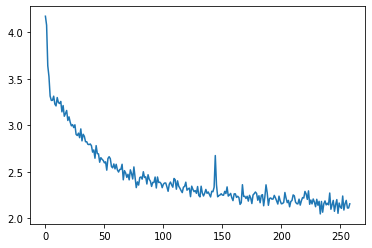

In [27]:
plt.figure()
plt.plot(record['loss'])
plt.show()

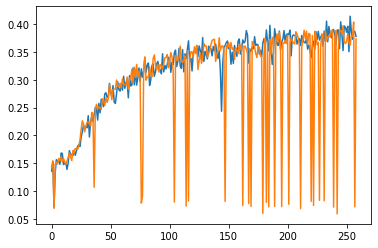

In [28]:
plt.figure()
plt.plot(record['trainAC'])
plt.plot(record['testAC'])
plt.show()

In [29]:
print(generate(model, device)) #default tau = 0.8

Juliet Fisster.

SETCHOS:
For and doon wall engle.

Srout, sith bm dath mrouch the with koud, and
And sell ponder ruther arven come, jrie lastend
Whithinind


In [30]:
print(generate(model, device, seed='juliet', tau=0.1), '\n') #deterministic
print(generate(model, device, seed='juliet', tau=2), '\n') #radom

juliet the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t 

juliet;ly; vat ror ,int;
Whcidroubdileeg,
Ots CRyyot Dawby,armlangd, s!oof raLgiscazunst, cony:asve kgoeZll O jtadchid?
ThyR?utoing apfeccvings-! Toen she,  



In [31]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #middle, produce longer

i will databer thaiger prother shis a fbeser, wehecear mall all elle, a, whatre she mure cingerut her she hace nase pors the daderens,
shatos woth mopned garsy lipe tham thense
Thut ip,
Sath this
Tpelimen.

MAPORN:
I there farcae, I ip freand, add armsand, head mantuns preeter me late
Ming mam;
Sast!
Thind man oum noce: fant the foatush sung the surs, Ondoy; Got the the he, a yue here fuch nems.

CAINA:
And shar hing all eer vy why as of in in as haad not this a thead the sarn.

DALNANAE:
She fore mer 



In [32]:
calc_accuracy(model, test_data, n_batch=len(test_data)-1, device=device)

0.3456743359565735

In [33]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n')

i will of ponter at isone.

PENOEE:
Core so tqouther shich sisting you his the to so praund some thow for to wo so ave kan ous he velle that not Sanse of perget and as bath no lrourw gollest he for tut the gond to coy hoage me, porses?
Tot-R
Therid ard wo sreter of hoving in, merery wir is bome thas melver,
My ank fause at als wiite of bally lolt,,
Here nor his hind srage kis onuteine we wher, sterter, an,
If have then he moneshe faundster diw my bade.
Whoun me quance bester-y
Praake wistisul
of thear 



In [34]:
print(generate(model, device, seed='i will', predict_len=500, tau=0.8), '\n') #honours

i will dorth is enderfert if in the sather woud the thea!

CTPEVES:
Nor pintt forshen be coe?

YRIANI:
Meor hem at it us at bave, ard, I frimon, slaot. Go whade dapest thou: cuwf with for whis so, wous hath there gord hen'd me sir'sed bo'n;
Bow a shen, beat pel there not he: ous to of the' do memes to for and sheam: candy kound ere, af the a there it the cich dath,
Wher not to thas moud; liy hath her hall her thou and the blove sotitith adferestasly beder, the my goth and dest thow my srofe, 'hat me h 

